## 0. Setup

In [1]:
import torch
import torchvision
import torchvision.transforms as T
import matplotlib.pyplot as plt
from EIANN import Network
import EIANN.utils as ut
import EIANN.plot as pt

pt.update_plot_defaults()


# Load dataset
tensor_flatten = T.Compose([T.ToTensor(), T.Lambda(torch.flatten)])
MNIST_train_dataset = torchvision.datasets.MNIST(root='../datasets/MNIST_data/', train=True, download=False,
                                         transform=tensor_flatten)
MNIST_test_dataset = torchvision.datasets.MNIST(root='../datasets/MNIST_data/',
                                        train=False, download=False,
                                        transform=tensor_flatten)

# Add index to train & test data
MNIST_train = []
for idx,(data,target) in enumerate(MNIST_train_dataset):
    target = torch.eye(len(MNIST_train_dataset.classes))[target]
    MNIST_train.append((idx, data, target))
    
MNIST_test = []
for idx,(data,target) in enumerate(MNIST_test_dataset):
    target = torch.eye(len(MNIST_test_dataset.classes))[target]
    MNIST_test.append((idx, data, target))
    
# Put data in dataloader
data_generator = torch.Generator()
train_dataloader = torch.utils.data.DataLoader(MNIST_train, shuffle=True, generator=data_generator)
train_sub_dataloader = torch.utils.data.DataLoader(MNIST_train[0:10000], shuffle=True, generator=data_generator)
val_dataloader = torch.utils.data.DataLoader(MNIST_train[-10000:], batch_size=10000, shuffle=False)
test_dataloader = torch.utils.data.DataLoader(MNIST_test, batch_size=10000, shuffle=False)

epochs = 1
data_seed = 0
network_seed = 42

### Backprop (no weight contraints)

Epochs:   0%|          | 0/1 [00:00<?, ?it/s]

Samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Batch accuracy = 94.44000244140625%


/Users/ag1880/Github_repos/Milstein-Lab/EIANN/EIANN/plot.py:906: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


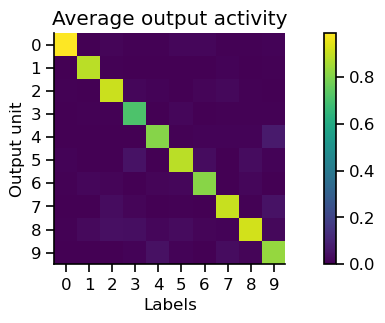

<Figure size 1000x300 with 0 Axes>

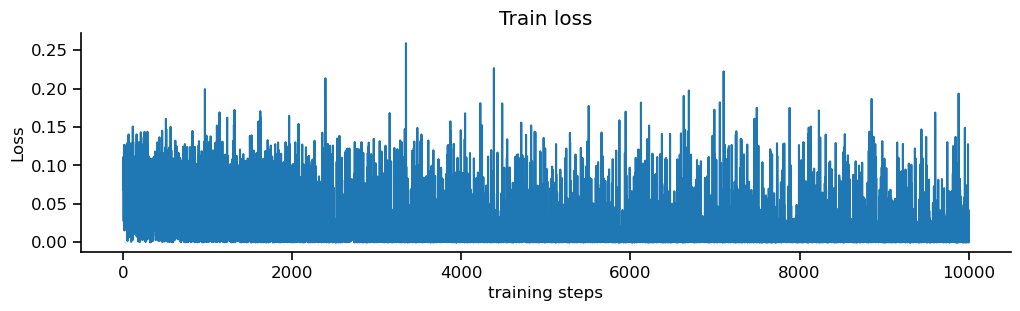

In [168]:
# Create network
network_config = ut.read_from_yaml('../config/MNIST/EIANN_1_hidden_mnist_backprop_relu_SGD_config.yaml')
layer_config = network_config['layer_config']
projection_config = network_config['projection_config']
training_kwargs = network_config['training_kwargs']

bp_network = Network(layer_config, projection_config, seed=network_seed, **training_kwargs)

# Train network
data_generator.manual_seed(data_seed)
bp_network.train_and_validate(train_sub_dataloader, 
                              test_dataloader, 
                              epochs=epochs,
                              val_interval=(0,-1,100),
                              store_history=False, 
                              store_weights=False, 
                              status_bar=True)

pt.plot_batch_accuracy(bp_network, test_dataloader)
plt.figure()
pt.plot_train_loss_history(bp_network)
plt.title('Train loss')
plt.show()

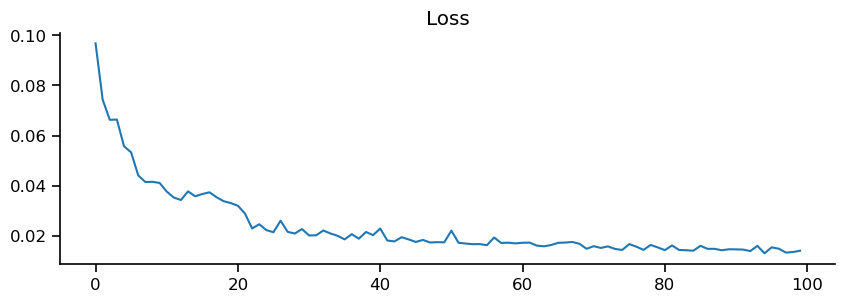

In [219]:
# pt.plot_test_loss_history(bp_network, test_dataloader, stepsize=50)
# pt.plot_MNIST_examples(bp_network, test_dataloader)
plt.figure()
plt.plot(bp_network.val_loss_history)
plt.title('Loss')
plt.show()

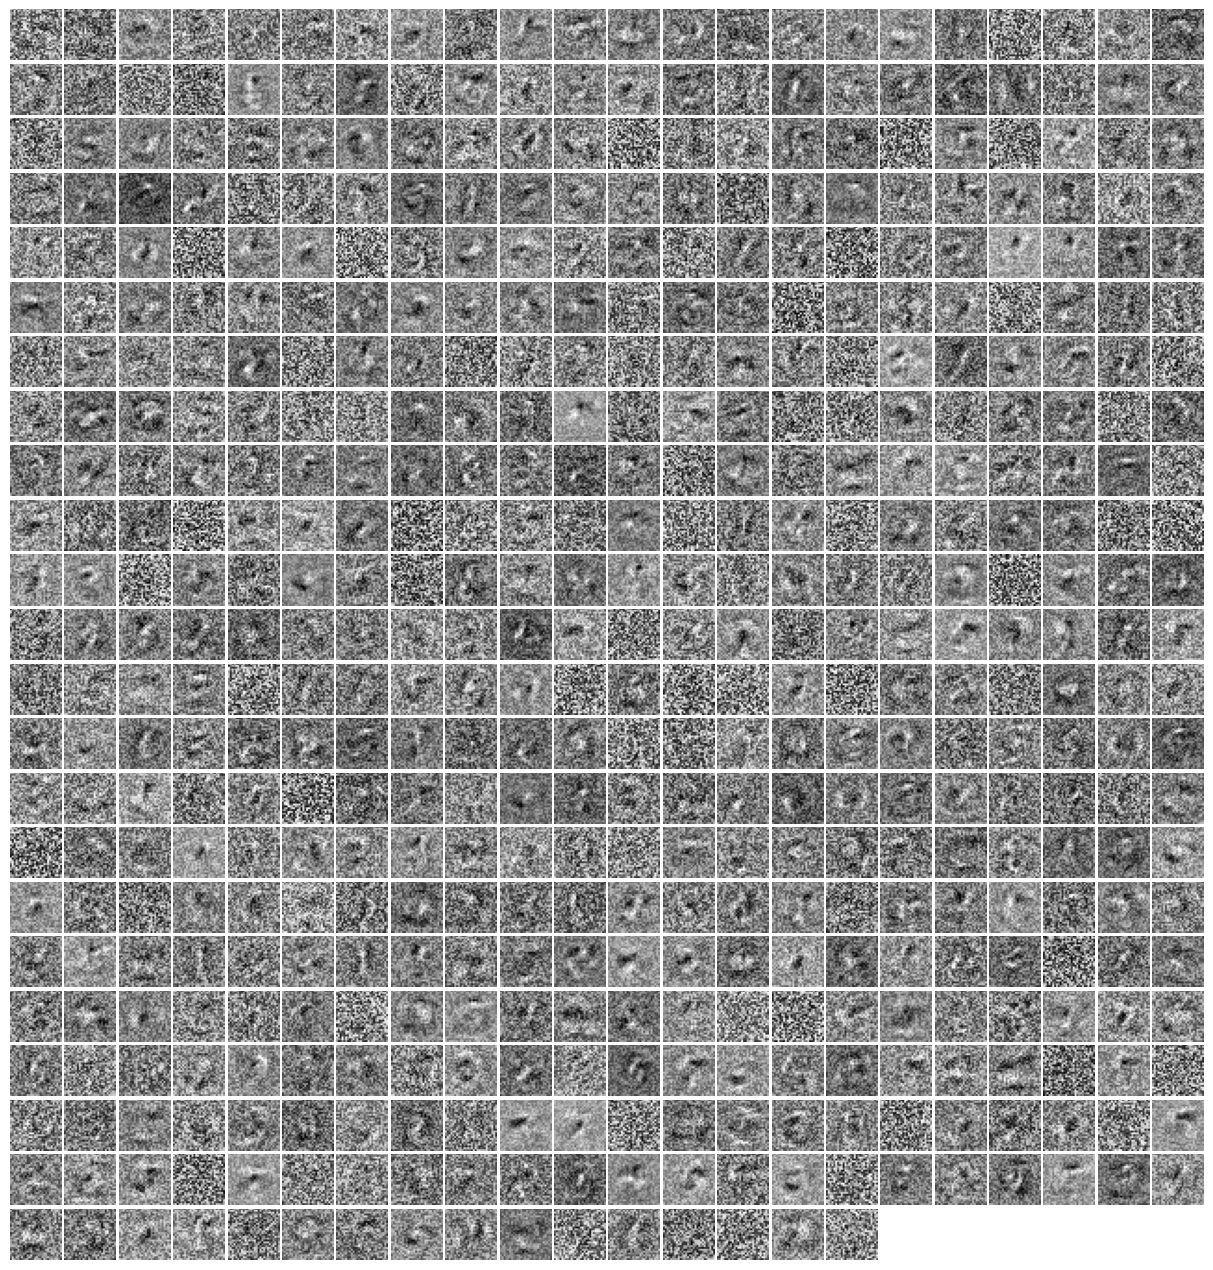

In [220]:
pt.plot_hidden_weights(bp_network.module_dict['H1E_InputE'].weight.detach())

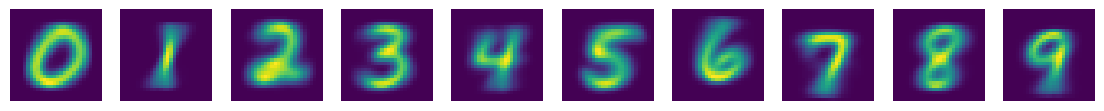

In [365]:
network = bp_network

# Plot activity-weighted average input for each output unit
idx, data, target = next(iter(test_dataloader))
output = network(data).detach()

num_output_units = output.shape[1]

fig, ax = plt.subplots(1,num_output_units,figsize=(14,5))

for i,label in enumerate(range(num_output_units)):
    weighting = output[:,label]
    weighted_average = (data.T@weighting)/weighting.sum()
    img = weighted_average.view(28,28)
    im = ax[i].imshow(img)
    ax[i].axis('off')
    
plt.show()

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:06<00:00, 1438.65it/s]


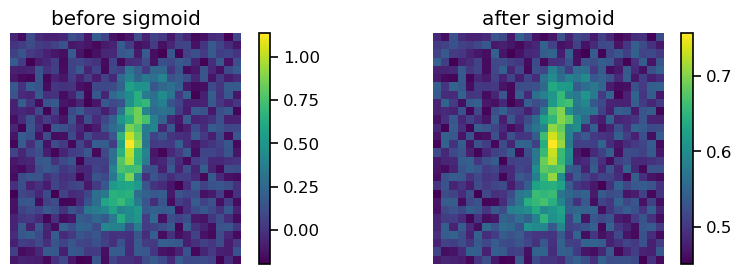

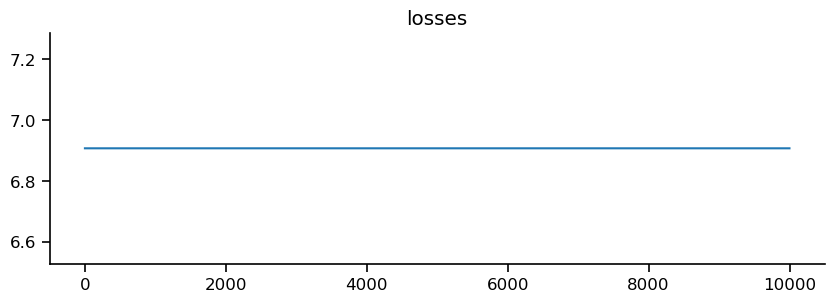

tensor([0.0000, 0.6349, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000])
tensor([0.0068, 0.0000, 0.1193, 0.0000, 0.0000, 0.0490, 0.0000, 0.0000, 0.2008,
        0.0000])


In [496]:
from tqdm import tqdm
import numpy as np
network = bp_network
output_unit = 1

# Find activity-weighted average input for the unit
idx, data, target = next(iter(test_dataloader))
output = network(data).detach()
unit_activity = output[:,output_unit]
weighted_avg_input = (data.T@unit_activity)/unit_activity.sum()


# Initialize a tensor to store the input image
random_noise = torch.empty(1, network.Input.E.size).uniform_(-0.2,0.2)
input_image = weighted_avg_input + random_noise
# input_image = weighted_avg_input/100

learning_rate = 0.1
num_steps = 10000

input_image.requires_grad = True
optimizer = torch.optim.SGD([input_image], lr=learning_rate)

losses = []
for step in tqdm(range(num_steps)):
    im = torch.sigmoid(input_image) #+ torch.empty(1,network.Input.E.size).uniform_(0.4,0.6)

    output = network(im)
    loss = -torch.log(output[output_unit]+0.001)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    losses.append(loss.detach())
    
input_image.requires_grad = False

fig, ax = plt.subplots(1,2)

img = input_image.view(28, 28)
im = ax[0].imshow(img)
plt.colorbar(im,ax=ax[0])
ax[0].axis('off')
ax[0].set_title('before sigmoid')

img = torch.sigmoid(img)
im = ax[1].imshow(img)
plt.colorbar(im,ax=ax[1])
ax[1].axis('off')
ax[1].set_title('after sigmoid')
plt.show()

plt.plot(losses)
plt.title('losses')
plt.show()

print(network(torch.sigmoid(input_image)).detach())

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:10<00:00, 976.91it/s]


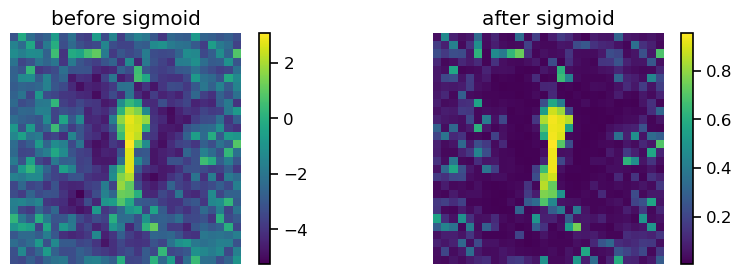

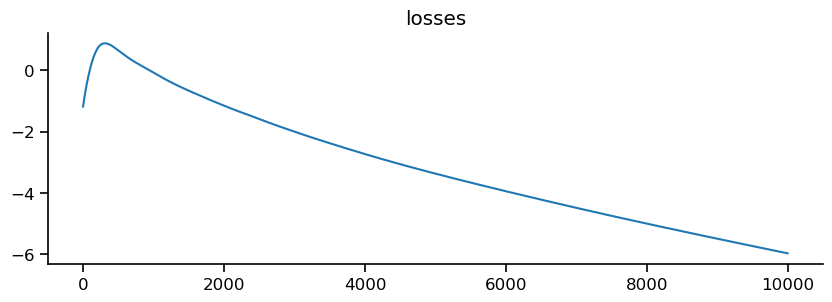

tensor([ 0.0000, 23.7546,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.2434,
         0.0000,  0.0000])
tensor([0.0000, 1.4822, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000])


In [513]:
from tqdm import tqdm
import numpy as np
network = bp_network
output_unit = 1

# Find activity-weighted average input for the unit
idx, data, target = next(iter(test_dataloader))
output = network(data).detach()
unit_activity = output[:,output_unit]
weighted_avg_input = (data.T@unit_activity)/unit_activity.sum()


# Initialize a tensor to store the input image
# input_image = torch.empty(1, network.Input.E.size).uniform_(0.5,0.6)
# input_image = torch.ones(1, network.Input.E.size)*0.5
# input_image = torch.empty(1, network.Input.E.size).uniform_(0.4,0.6) + weighted_avg_input/10
input_image = torch.zeros(1, network.Input.E.size)

learning_rate = 0.1
num_steps = 10000

input_image.requires_grad = True
optimizer = torch.optim.SGD([input_image], lr=learning_rate)

losses = []
for step in tqdm(range(num_steps)):
#     im = torch.sigmoid(input_image) + data[np.random.randint(data.shape[0])]/(np.log(step/100+1)+0.1)
    im = torch.sigmoid(input_image) + weighted_avg_input/(np.log(step/1000+1)+0.1)
#     im = torch.sigmoid(input_image)
    
    output = network(im)
    loss = -torch.log(output[output_unit]+0.001) + 2*torch.mean(input_image)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    losses.append(loss.detach())
    
input_image.requires_grad = False

fig, ax = plt.subplots(1,2)

img = input_image.view(28, 28)
im = ax[0].imshow(img)
plt.colorbar(im,ax=ax[0])
ax[0].axis('off')
ax[0].set_title('before sigmoid')

img = torch.sigmoid(img)
im = ax[1].imshow(img)
plt.colorbar(im,ax=ax[1])
ax[1].axis('off')
ax[1].set_title('after sigmoid')
plt.show()

plt.plot(losses)
plt.title('losses')
plt.show()

print(network(input_image).detach())
print(network(torch.sigmoid(input_image)).detach())

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:10<00:00, 985.31it/s]


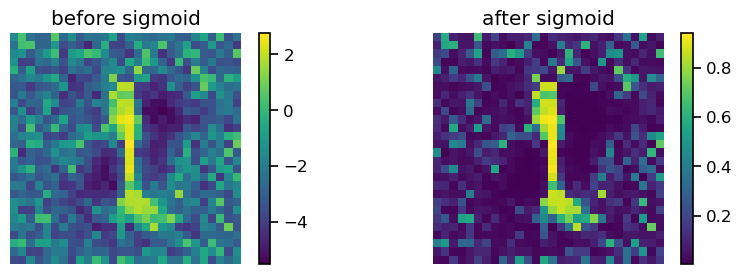

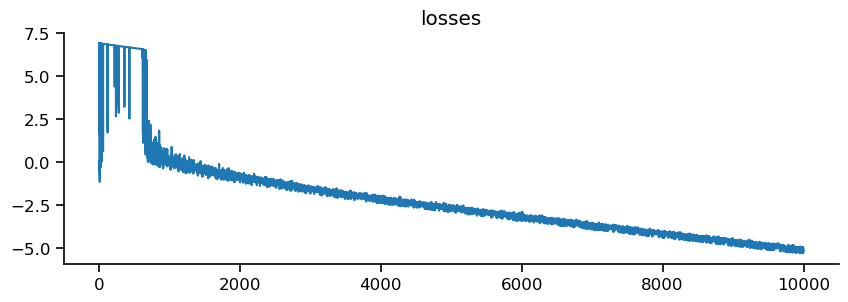

tensor([ 0.0000, 18.8251,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000])
tensor([0.0000, 1.4270, 0.0000, 0.0000, 0.0000, 0.0804, 0.0000, 0.0000, 0.0000,
        0.0000])


In [514]:
from tqdm import tqdm
import numpy as np
network = bp_network
output_unit = 1

# Find activity-weighted average input for the unit
idx, data, target = next(iter(test_dataloader))
output = network(data).detach()
unit_activity = output[:,output_unit]
weighted_avg_input = (data.T@unit_activity)/unit_activity.sum()


# Initialize a tensor to store the input image
# input_image = torch.empty(1, network.Input.E.size).uniform_(0.5,0.6)
# input_image = torch.ones(1, network.Input.E.size)*0.5
# input_image = torch.empty(1, network.Input.E.size).uniform_(0.4,0.6) + weighted_avg_input/10
input_image = torch.zeros(1, network.Input.E.size)

learning_rate = 0.1
num_steps = 10000

input_image.requires_grad = True
optimizer = torch.optim.SGD([input_image], lr=learning_rate)

losses = []
for step in tqdm(range(num_steps)):
    im = torch.sigmoid(input_image) + data[np.random.randint(data.shape[0])]/(np.log(step/100+1)+0.1)
#     im = torch.sigmoid(input_image) + weighted_avg_input/(np.log(step/1000+1)+0.1)
#     im = torch.sigmoid(input_image)
    
    output = network(im)
    loss = -torch.log(output[output_unit]+0.001) + 2*torch.mean(input_image)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    losses.append(loss.detach())
    
input_image.requires_grad = False

fig, ax = plt.subplots(1,2)

img = input_image.view(28, 28)
im = ax[0].imshow(img)
plt.colorbar(im,ax=ax[0])
ax[0].axis('off')
ax[0].set_title('before sigmoid')

img = torch.sigmoid(img)
im = ax[1].imshow(img)
plt.colorbar(im,ax=ax[1])
ax[1].axis('off')
ax[1].set_title('after sigmoid')
plt.show()

plt.plot(losses)
plt.title('losses')
plt.show()

print(network(input_image).detach())
print(network(torch.sigmoid(input_image)).detach())

1

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

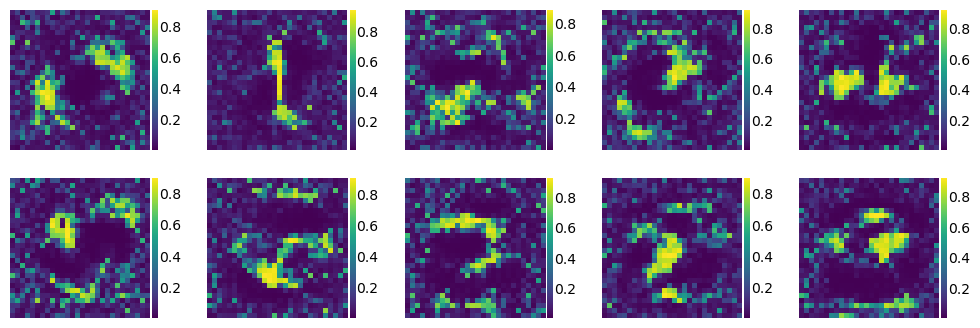

In [578]:
from tqdm.notebook import tqdm
import numpy as np
import matplotlib.gridspec as gs

network = bp_network


idx, data, target = next(iter(test_dataloader))
learning_rate = 0.1
num_steps = 10000


num_rows = 2
num_cols = 5
axes = gs.GridSpec(num_rows, num_cols,
                   wspace=0.4, hspace=0.2)
fig = plt.figure(figsize=(12, 4))


for i,output_unit in enumerate(range(10)):
    row_idx = i // num_cols
    col_idx = i % num_cols

    input_image = torch.zeros(1, network.Input.E.size) # initialize a tensor to store the input image
    input_image.requires_grad = True
    optimizer = torch.optim.SGD([input_image], lr=learning_rate)

    for step in tqdm(range(num_steps)):
        im = torch.sigmoid(input_image) + data[np.random.randint(data.shape[0])]/(np.log(step/100+1)+0.1)

        output = network(im)
        loss = -torch.log(output[output_unit]+0.001) + 2*torch.mean(input_image)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    input_image.requires_grad = False
    img = torch.sigmoid(input_image.view(28, 28))
    
    ax = fig.add_subplot(axes[row_idx, col_idx])
    im = ax.imshow(img)
    cax = fig.add_axes([ax.get_position().x1 + 0.002, ax.get_position().y0, 0.005, ax.get_position().height])
    cbar = plt.colorbar(im, cax=cax)
    cbar.outline.set_visible(False)
    cbar.ax.tick_params(labelsize=10, pad=0.5, length=0) 

    ax.axis('off')
    
plt.show()

### Backprop (Dale's Law)

In [2]:
# Create network
network_config = ut.read_from_yaml('../config/MNIST/EIANN_1_hidden_mnist_backprop_Dale_relu_SGD_config.yaml')
layer_config = network_config['layer_config']
projection_config = network_config['projection_config']
training_kwargs = network_config['training_kwargs']

bpDale_network = Network(layer_config, projection_config, seed=network_seed, **training_kwargs)

# Train network
data_generator.manual_seed(data_seed)
bpDale_network.train_and_validate(train_sub_dataloader, 
                              val_dataloader, 
                              epochs=epochs,
                              val_interval=(-200,-1,10),
                              store_history=False, 
                              store_weights=False, 
                              status_bar=True)

ut.compute_batch_accuracy(bpDale_network, test_dataloader)
plt.figure()
pt.plot_train_loss_history(bpDale_network)
plt.title('Train loss')
plt.show()

Epochs:   0%|          | 0/1 [00:00<?, ?it/s]

Samples:   0%|          | 0/10000 [00:00<?, ?it/s]

tensor(0.0006)

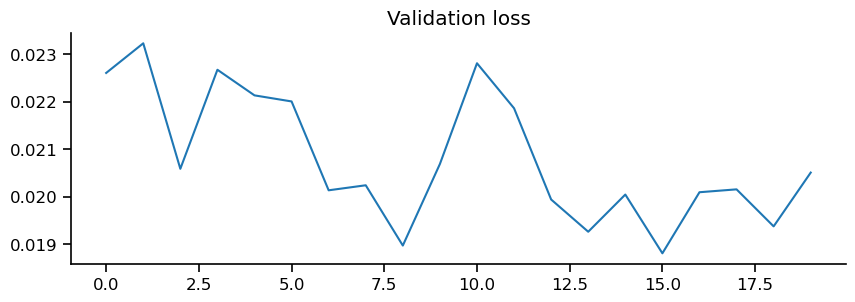

In [5]:
# pt.plot_test_loss_history(bpDale_network, test_dataloader, stepsize=50)
# pt.plot_MNIST_examples(bpDale_network, test_dataloader)
plt.figure()
plt.plot(bpDale_network.val_loss_history)
plt.title('Validation loss')
plt.show()

In [ ]:
# Train network
bpDale_network.reset_history()

data_generator.manual_seed(data_seed)
bpDale_network.train_and_validate(train_sub_dataloader, 
                              val_dataloader, 
                              epochs=epochs,
                              val_interval=(-200,-1,10),
                              store_history=True, 
                              store_weights=False, 
                              status_bar=True)

In [ ]:
from EIANN.plot import *

fig,ax = plt.subplots(2,2,figsize=(12,4))

t = 0
hidden_activity = torch.mean(bpDale_network.H1.E.activity_history[t], dim=1)
output_activity = torch.mean(bpDale_network.Output.E.activity_history[t], dim=1)
ax[0,0].plot(hidden_activity,'--',color='r', label='H1E')
ax[0,0].plot(output_activity,color='r', label='OutputE')
ax[0,0].set_title('Before training')
ax[0,0].legend()

hiddenFBI_activity = torch.mean(bpDale_network.H1.FBI.activity_history[t], dim=1)
outputFBI_activity = torch.mean(bpDale_network.Output.FBI.activity_history[t], dim=1)
ax[1,0].plot(hiddenFBI_activity,'--',color='b', label='H1FBI')
ax[1,0].plot(outputFBI_activity,color='b', label='OutputFBI')


t = -1
hidden_activity = torch.mean(bpDale_network.H1.E.activity_history[t], dim=1)
output_activity = torch.mean(bpDale_network.Output.E.activity_history[t], dim=1)
ax[0,1].plot(hidden_activity,'--',color='r', label='H1E')
ax[0,1].plot(output_activity,color='r', label='OutputE')
ax[0,1].set_title('After training')
ax[0,1].legend()

hiddenFBI_activity = torch.mean(bpDale_network.H1.FBI.activity_history[t], dim=1)
outputFBI_activity = torch.mean(bpDale_network.Output.FBI.activity_history[t], dim=1)
ax[1,1].plot(hiddenFBI_activity,'--',color='b', label='H1FBI')
ax[1,1].plot(outputFBI_activity,color='b', label='OutputFBI')

plt.show()

## BTSP

In [ ]:
# Create network
network_config = ut.read_from_yaml('../config/MNIST/20221219_EIANN_1_hidden_mnist_BTSP_config_D.yaml') 
layer_config = network_config['layer_config']
projection_config = network_config['projection_config']
training_kwargs = network_config['training_kwargs']

btsp_network = Network(layer_config, projection_config, seed=network_seed, **training_kwargs)

# Train network
data_generator.manual_seed(data_seed)

data_generator.manual_seed(data_seed)
btsp_network.train_and_validate(train_sub_dataloader, 
                              val_dataloader, 
                              epochs=epochs,
                              val_interval=(-200,-1,10),
                              store_history=False, 
                              store_weights=False, 
                              status_bar=True)

In [ ]:
ut.compute_batch_accuracy(btsp_network, test_dataloader)
plt.figure()
pt.plot_train_loss_history(btsp_network)
plt.title('Train loss')
plt.show()
# pt.plot_test_loss_history(btsp_network, test_dataloader, stepsize=50)
# pt.plot_MNIST_examples(btsp_network, test_dataloader)
plt.figure()
plt.plot(btsp_network.val_loss_history)
plt.title('Validation loss')
plt.show()